# Testing the BoolFunction class for probabilistic boolean function learning

In [1]:
import babool as bb
import numpy as np

## Generating data

In [2]:
# For replication purposes, set seed to 1910
np.random.seed(1910)

In [3]:
# First scenario
N = 2000
p = 100
ktrue = 2
k2true = 2
phitrue = list(range(ktrue))
phitrue2 = list(range(ktrue, ktrue + k2true))
p0true = 0.1
p1true = 0.9

### Two markers

In [4]:
def generate_data_m2(N, p):
    
    # Marker
    markers = [list(range(ktrue)), list(range(ktrue, ktrue + k2true))]

    M = np.zeros(shape = (N, p))
    y = np.zeros(shape = (N))

    # Generate marginal probabiliites for X
    pvar = np.random.uniform(low= 0.4, high = 0.5, size = p)

    nmarked1 = 0
    nmarked2 = 0

    for cont in range(N):
        v = np.random.binomial(n = 1, p = pvar, size = (1, p))

        # Apply marker 1
        mark = v[:, markers[0]].prod()

        if mark > 0:
            nmarked1 += 1
            u = np.random.binomial(1, p1true)
        else:
            # Apply marker 2
            mark = v[:, markers[1]].prod()

            if mark > 0:
                nmarked2 += 1
                u = np.random.binomial(1, p1true)
            else:
                u = np.random.binomial(1, p0true)

        M[cont, :] = v
        y[cont] = u
        
    return M, y, nmarked1, nmarked2

M, y, nmarked1, nmarked2 = generate_data_m2(N, p)        
print("{} affected with {} marked individuals for term 1 and {} marked individuals for term 2 on a total of {} cases".format(sum(y), nmarked1, nmarked2, N))

695.0 affected with 323 marked individuals for term 1 and 288 marked individuals for term 2 on a total of 2000 cases


In [5]:
# Taking the conjunction of all affected individuals
# If effect is decisive, this should match phi exactly given N is large enough (See paper)
v = np.where(np.prod(M[y==1], axis = 0) == 1)
print("Conjunction = {}".format(v[0]))

# Verifying if any pair of variables is equivalent
minsum = 100000
for i in range(p):
    for j in range(i+1, p):
        s = np.sum(np.abs(M[:,i] - M[:, j]))
        if s < minsum:
            minsum = s
            imin = i
            jmin = j
            
print("Minimum distance = {} for columns {} and {}".format(s, imin, jmin))    

Conjunction = []
Minimum distance = 993.0 for columns 3 and 4


# Descriptive analysis

In [6]:
import pandas as pd
from matplotlib import pyplot as plt

In [7]:
# Creates pandas data frame
dfsim = pd.DataFrame.from_records(np.c_[y, M])

In [8]:
# Pyplot parameter
plt.rcParams.update({'font.size' : 22})

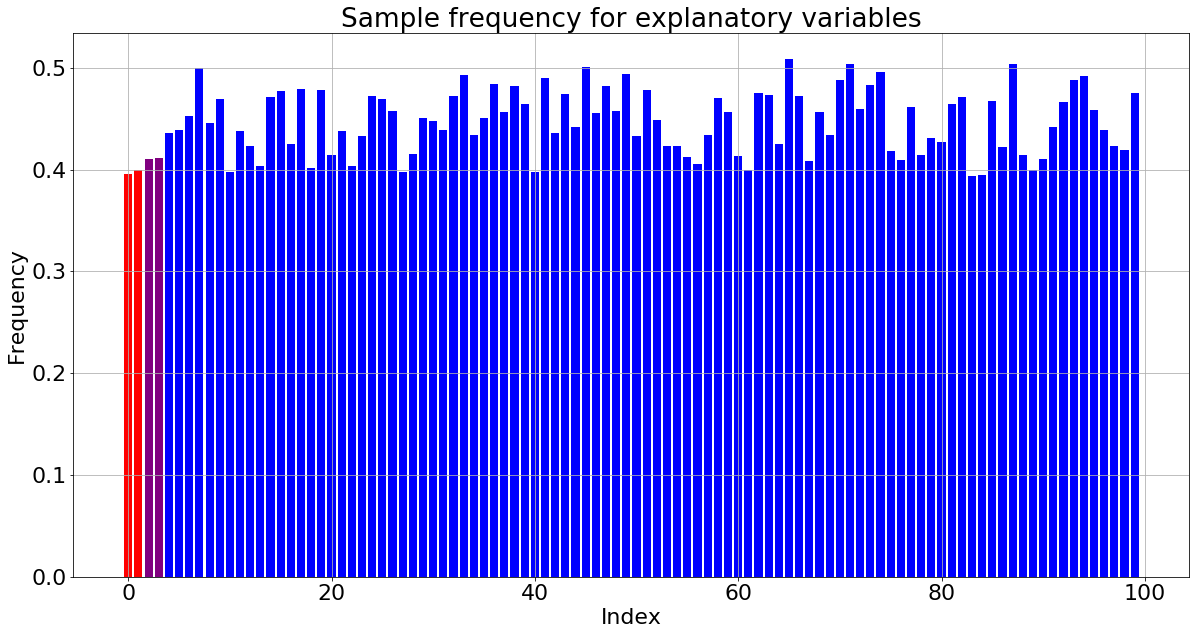

In [9]:
# Sample frequency for columns of M
fig = plt.figure(figsize = (20, 10))

colors = ['blue'] * p
for i in phitrue:
    colors[i] = 'red'
for j in phitrue2:
    colors[j] = 'purple'

prop = M.mean(axis = 0)
plt.bar(x = range(p), height = prop, color = colors)
plt.grid(True)
plt.title("Sample frequency for explanatory variables")
plt.xlabel("Index")
plt.ylabel("Frequency")
#plt.savefig(figdir + 'rare_common_plot1.png')
plt.show()

### Sample odds ratio for each column of M

In [10]:
oddsr = np.zeros(p)
for i in range(p):
    soma = sum(1-y[M[:,i] == 1])
    if soma > 0:
        o1 = sum(y[M[:,i] == 1]) / soma
    else:
        o1 = 0
    soma = sum(1-y[M[:,i] == 0])
    if soma > 0:
        o2 = sum(y[M[:,i] == 0]) / soma        
    else:
        o2 = 0
        
    if o2 > 0:
        oddsr[i] = o1 / o2
    else:
        oddsr[i] = 0

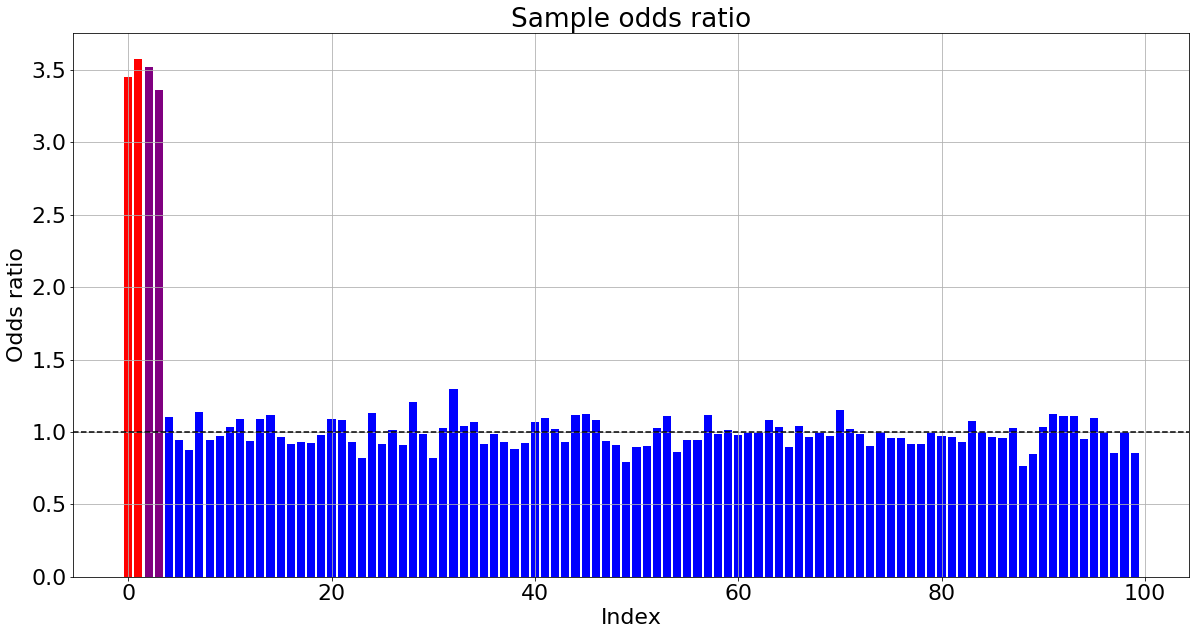

In [11]:
fig = plt.figure(figsize = (20, 10))

colors = ['blue'] * p

for i in phitrue:
    colors[i] = 'red'
for j in phitrue2:
    colors[j] = 'purple'
    
plt.bar(x = range(p), height = oddsr, color = colors)
plt.axhline(xmin = 0, xmax = p, y = 1.0, color = 'black', linestyle = '--')

plt.grid(True)
plt.title("Sample odds ratio")
plt.xlabel("Index")
plt.ylabel("Odds ratio")
plt.show()

### Association (chi-squared independence) test

In [12]:
from scipy.stats import chi2_contingency

pvalues = -np.ones(shape = (p))
for i in range(p):
    dftmp = pd.crosstab(M[:,i], y)
    pvalues[i] = chi2_contingency(dftmp)[1]

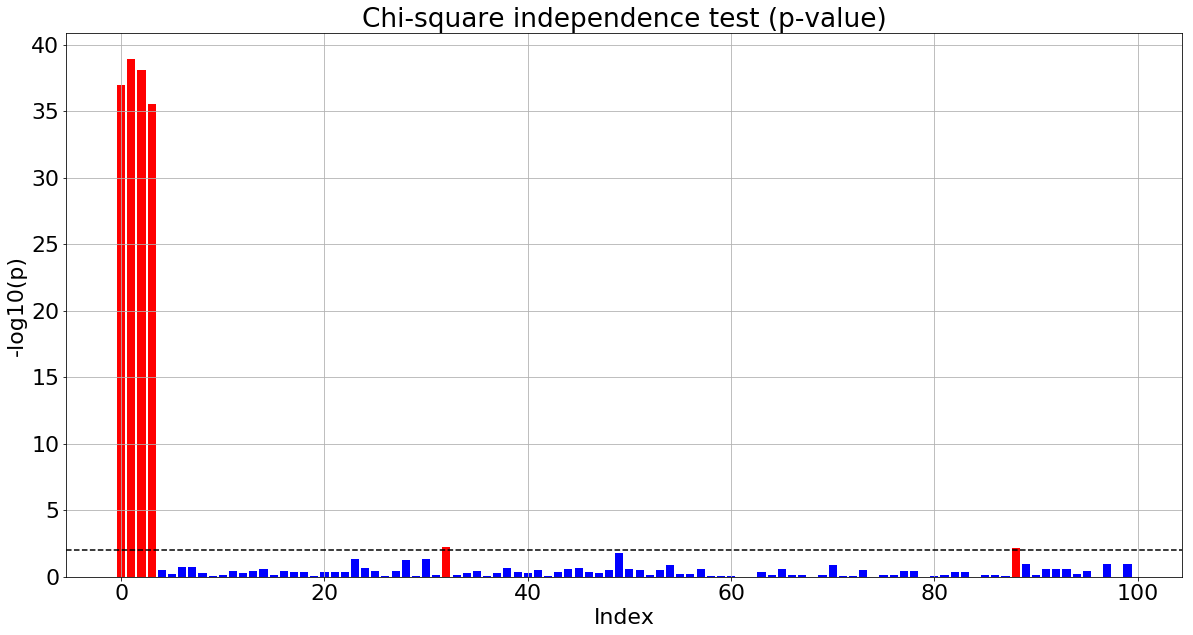

In [13]:
# P-value threshold to color the bars
threshold = 0.01

fig = plt.figure(figsize = (20, 10))

colors = ['blue'] * p
for i in range(p):
    if pvalues[i] < threshold:
        colors[i] = 'red'
        
plt.bar(x = range(p), height = -np.log10(pvalues), color = colors)
plt.axhline(xmin = 0, xmax = p, y = 2, linestyle = '--', color = 'black')
plt.grid(True)
plt.ylabel("-log10(p)")
plt.xlabel("Index")
plt.title("Chi-square independence test (p-value)")
plt.show()

## Probabilistic Boolean function learning

### Creates object

In [5]:
model = bb.BoolFunction(pgeomm = None, theta = 10)

### Train model

In [6]:
%%time
nchains = 1
njobs = -1
nsteps = 10000
nstart = 20

results = model.fit(M, y, nchains, njobs, nsteps, nstart )

CPU times: user 72.3 ms, sys: 28.6 ms, total: 101 ms
Wall time: 14.9 s


In [20]:
for r in results:
    print("f = {}".format(r[0][0]))
    print("p0 = {:.4f}. p1 = {:.4f}".format(r[0][1], r[0][2]))
    print("Post = {:.4f}".format(r[1]))

f = [[0, 1]]
p0 = 0.2382. p1 = 0.9138
Post = -1020.6890


In [7]:
model.post(p0true, p1true, markers)

NameError: name 'markers' is not defined

### Testing combinations

In [99]:
m0 = [1]
lnchains = [20]
ltheta = [10]
lpgeomm = [0.5]
Ns = [100, 250, 500]

Testing for 10 simulated datasets

In [100]:
nsim = 10

In [103]:
%%time
np.random.seed(1910)

njobs = -1
nsteps = 10000

optim = []
N = 1000
for N in Ns:
    for ii in range(nsim):

        M, y, n1, n2 = generate_data_m2(N, p)
        print("Run {} - {} marked 1, {} marked 2".format(ii, n1, n2))
        for i in range(len(lnchains)):
            nchains = lnchains[i]
            for k in range(len(m0)):
                nstart = m0[k]
                for j in range(len(ltheta)):
                    theta = ltheta[j]
                    pgeomm = lpgeomm[j]

                    model = bb.BoolFunction(pgeomm = pgeomm, theta = theta)
                    results = model.fit(M, y, nchains, njobs, nsteps, nstart)

                    optim.append([ii, N, nstart, nchains, theta, pgeomm, model.psi, model.p0, model.p1])


Run 0 - 16 marked 1, 12 marked 2
Run 1 - 19 marked 1, 18 marked 2
Run 2 - 14 marked 1, 20 marked 2
Run 3 - 17 marked 1, 17 marked 2
Run 4 - 15 marked 1, 11 marked 2
Run 5 - 29 marked 1, 15 marked 2
Run 6 - 16 marked 1, 22 marked 2
Run 7 - 25 marked 1, 15 marked 2
Run 8 - 25 marked 1, 13 marked 2
Run 9 - 15 marked 1, 19 marked 2
Run 0 - 47 marked 1, 46 marked 2
Run 1 - 57 marked 1, 50 marked 2
Run 2 - 48 marked 1, 33 marked 2
Run 3 - 56 marked 1, 36 marked 2
Run 4 - 47 marked 1, 47 marked 2
Run 5 - 49 marked 1, 46 marked 2
Run 6 - 53 marked 1, 35 marked 2
Run 7 - 40 marked 1, 41 marked 2
Run 8 - 57 marked 1, 40 marked 2
Run 9 - 50 marked 1, 34 marked 2
Run 0 - 114 marked 1, 82 marked 2
Run 1 - 100 marked 1, 74 marked 2
Run 2 - 113 marked 1, 84 marked 2
Run 3 - 107 marked 1, 74 marked 2
Run 4 - 106 marked 1, 80 marked 2
Run 5 - 90 marked 1, 93 marked 2
Run 6 - 107 marked 1, 71 marked 2
Run 7 - 121 marked 1, 78 marked 2
Run 8 - 124 marked 1, 75 marked 2
Run 9 - 102 marked 1, 97 marked 2
C

In [104]:
import pickle

with open('res3.pkl', 'wb') as arq:
    pickle.dump(optim, arq)

### Formatting output

In [105]:
def convert_f(l):
    ret = ''
    sortm = []
    for m in l:
        m.sort()
        mstart = m[0]
        if len(sortm) == 0:
            sortm.append(m)
        else:
            i = 0
            while i < len(sortm) and sortm[i][0] < mstart:
                i += 1
            sortm.insert(i, m)
    
    for m in sortm:
        for i in m:
            ret += 'x' + str(i)
        ret += ' + '
        
    return ret[:-3]
            

In [107]:
import pandas as pd

#dfres = pd.DataFrame({'run' : [o[0] for o in optim], 'nstart' : [o[1] for o in optim], 'nchains' : [o[2] for o in optim], 'theta' : [o[3] for o in optim], 'pgeom' : [o[4] for o in optim], 'psi' : [convert_f(o[5]) for o in optim], 'p0' : [o[6] for o in optim], 'p1' : [o[7] for o in optim]})
dfres = pd.DataFrame({'run' : [o[0] for o in optim], 'N' : [o[1] for o in optim],'psi' : [convert_f(o[6]) for o in optim], 'p0' : [o[7] for o in optim], 'p1' : [o[8] for o in optim]})

In [108]:
import re

def find_term_1(s):
    i = re.findall('x0x1(?:\s|$)', s)
    if len(i) > 0:
        return 1
    else:
        return 0
    
    
def find_term_2(s):
    i = re.findall('(?:\s|^)x2x3(?:\s|$)', s)
    if len(i) > 0:
        return 1
    else:
        return 0
    
    
dfres['m'] = dfres.psi.apply(lambda l: len(l.split('+')))
dfres['sum k'] = dfres.psi.apply(lambda l: l.count('x'))
dfres['term1'] = dfres.psi.apply(find_term_1)
dfres['term2'] = dfres.psi.apply(find_term_2)

In [110]:
#dfres.sort_values(['nstart', 'nchains', 'theta', 'pgeom', 'run'])
dfres.sort_values(['N', 'run'])

,run,N,psi,p0,p1,m,sum k,term1,term2
0,0,100,x2x3,0.204545,0.875000,1,2,0,1
1,1,100,x0x1,0.313253,0.904762,1,2,1,0
2,2,100,x0x1,0.272727,0.937500,1,2,1,0
3,3,100,x0x1 + x2x3,0.058824,0.805556,2,4,1,1
4,4,100,x0x1,0.241379,0.941176,1,2,1,0
5,5,100,x2x3,0.282051,0.923077,1,2,0,1
6,6,100,x2x3,0.223684,0.928571,1,2,0,1
7,7,100,x0x1,0.246753,0.777778,1,2,1,0
8,8,100,x0x1,0.220779,0.888889,1,2,1,0
9,9,100,x2x3,0.227848,0.840000,1,2,0,1


In [93]:
dfres = dfres.fillna(0)

In [115]:
#table1 =  dfres.groupby(['nstart', 'nchains', 'theta', 'pgeom']).mean().reset_index()
#table1 = table1.drop(['run', 'theta', 'pgeom'], axis = 1)
table1 = dfres.groupby(['N']).mean().reset_index()
table1 = table1.drop(['run'], axis = 1)

In [116]:
def formatter(l):
    return '%1.2f' % l

print(table1.to_latex(index = False, formatters = {'p0' : formatter, 'p1' : formatter}))

\begin{tabular}{rrrrrrr}
\toprule
   N &   p0 &   p1 &    m &  sum k &  term1 &  term2 \\
\midrule
 100 & 0.23 & 0.88 &  1.1 &    2.2 &    0.6 &    0.5 \\
 250 & 0.18 & 0.90 &  1.5 &    3.0 &    0.7 &    0.8 \\
 500 & 0.11 & 0.88 &  1.9 &    3.8 &    0.9 &    1.0 \\
\bottomrule
\end{tabular}



In [96]:
table2 =  dfres.groupby(['nstart', 'nchains', 'theta', 'pgeom']).std().reset_index()
table2 = table2.drop(['run', 'term1', 'term2', 'theta', 'pgeom'], axis = 1)
print(table2.to_latex(index = False, formatters = {'p0' : formatter, 'p1' : formatter, 'size' : formatter, 'm' : formatter, 'sum k' : formatter}))

\begin{tabular}{rrrrrr}
\toprule
 nstart &  nchains &   p0 &   p1 &    m & sum k \\
\midrule
      1 &        1 & 0.05 & 0.02 & 0.32 &  0.63 \\
      1 &        2 & 0.08 & 0.02 & 0.52 &  1.03 \\
      1 &       20 & 0.01 & 0.02 & 0.32 &  2.21 \\
     10 &        1 & 0.07 & 0.02 & 0.52 &  1.03 \\
     10 &        2 & 0.08 & 0.01 & 0.52 &  1.03 \\
     10 &       20 & 0.05 & 0.02 & 0.32 &  0.63 \\
     20 &        1 & 0.08 & 0.02 & 0.52 &  1.03 \\
     20 &        2 & 0.07 & 0.01 & 0.48 &  0.97 \\
     20 &       20 & 0.01 & 0.02 & 0.32 &  1.58 \\
\bottomrule
\end{tabular}

